# Libraries, Data

In [ ]:
#pip install scikit-image

In [1]:
import os 
import pandas as pd
import numpy as np
import h5py
#import functions_read_data as rdat
# Tensorflow/Keras
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
os.chdir(DIR)
print(os.getcwd())
IMG_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/"
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/"
path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv'


# Own functions
from functions.plot_slices import plot_slices
# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters
from functions.augmentation3d import zoom, rotate, flip, shift

2.2.0
/tf/notebooks/schnemau/xAI_stroke_3d


Using TensorFlow backend.


In [2]:
import functions_model_definition as md
import functions_read_data as rdat
import functions_occlusion as oc
import functions_gradcam as gc
import functions_plot_heatmap as phm
import functions_slider as sl
import Utils_maurice as utils

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
which_split = 6
(train_idx, valid_idx, test_idx, X, X_train, X_valid, X_test, X_tab_train, X_tab_valid, X_tab_testt), (Y_train, Y_valid, Y_test), results, results2 = utils.read_and_split_img_data_andrea_maurice2(
    path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', 
    path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv', 
    path_splits = '/tf/notebooks/schnemau/xAI_stroke_3d/data/andrea_splits.csv', 
    split = which_split)

Y_train_MRS = to_categorical(Y_train)
Y_valid_MRS = to_categorical(Y_valid)
Y_test_MRS = to_categorical(Y_test)

# Ontram

In [5]:
C = Y_train_MRS.shape[1]
batch_size = 5
ntrain = 325
nvalid = 40
ntest = 40

## CIB

### Simple

In [5]:
ontram_1_occ = ontram(utils.img_model_linear_final(np.expand_dims(X_train, axis = -1).shape[1:], 1))
ontram_1_occ.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                                    loss=ontram_loss(C, batch_size),
                                    metrics=[ontram_acc(C, batch_size)])

ontram_1_occ.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIB_1.h5')

In [49]:
#ontram_1_occ.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/iniCIB_1.h5')
#ontram_1_occ.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_1_ontram_CIB_fini.h5')

In [6]:
occ_size = (14, 14, 10)
occ_stride = 6

###per patient input
volume = np.expand_dims(X_train, axis = -1)[0]

###
occlusion_size = np.array(occ_size)
normalize = True
both_directions = False
invert_hm = "pred_class"
occlusion_stride = occ_stride
input_shape = (128,128,28,1)
volume = volume.reshape(input_shape)

In [7]:
heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

## Generate all possible occlusions
X_occ = []
xyz = []
for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
            X_occ.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1)) #3 changed from 1 manually
            xyz.append((x,y,z))

X_occ_2 = np.array(X_occ)

In [8]:
data_loader_1 = X_occ_2
data_occ = tf.data.Dataset.from_tensor_slices((data_loader_1))
data_occ_labels = tf.data.Dataset.from_tensor_slices(np.repeat((Y_test_MRS[0],), 
                                                               repeats=len(X_occ_2), axis=0))
occ_loader = tf.data.Dataset.zip((data_occ, data_occ_labels))
data_occ_full = occ_loader.batch(5, drop_remainder = True)

In [9]:
predsss = predict_ontram(ontram_1_occ, data = data_occ_full)

In [22]:
results['threshold'].values[0]

0.14454684

In [19]:
results = pd.read_csv("/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/results_CIB.csv")
results.head()

,p_idx,p_id,mrs,unfavorable,status,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,372,516.0,1.0,0,test,0.006145,0.013803,0.006911,0.003871,0.008219,0.007790,0.007152,0.144547,0,0.003714,0.021673,True
1,284,376.0,2.0,0,test,0.021921,0.058106,0.018858,0.010962,0.027066,0.027382,0.023569,0.144547,0,0.018139,0.127213,True
2,298,390.0,2.0,0,test,0.111068,0.087966,0.063942,0.107128,0.120188,0.098058,0.095983,0.144547,0,0.022400,0.158384,True
3,203,286.0,0.0,0,test,0.170627,0.171170,0.130616,0.110473,0.268568,0.170291,0.164053,0.144547,1,0.060851,0.439709,False
4,292,384.0,0.0,0,test,0.008280,0.011323,0.008522,0.008535,0.013378,0.010008,0.009820,0.144547,0,0.002261,0.011041,True


In [25]:
for i in range(len(X_occ)):
    x,y,z = xyz[i]
    heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += predsss['pdf'][i][1]
    heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

In [26]:
hm_maurice = heatmap_prob_sum / heatmap_occ_n

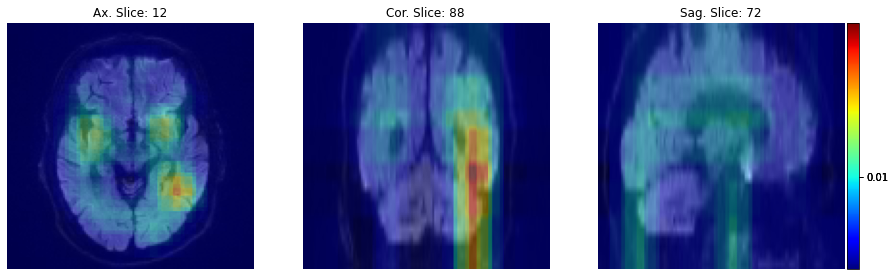

In [27]:
phm.plot_heatmap(X_test[5], hm_maurice,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True,
                negative = False)

In [ ]:
phm.plot_heatmap(np.squeeze(X_test[8], axis=-1), hm_maurice,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True,
                negative = False)

### Ensemble

In [7]:
occ_size = (14, 14, 10)
occ_stride = 6
###per patient input
volume = np.expand_dims(X_train, axis = -1)[0]

###
occlusion_size = np.array(occ_size)
occlusion_stride = occ_stride
input_shape = (128,128,28,1)
volume = volume.reshape(input_shape)

In [10]:
h_l = []
for j in range(5):
    model_ontram = ontram(utils.img_model_linear_final(np.expand_dims(X_train, axis = -1).shape[1:], 1))
    model_ontram.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                                    loss=ontram_loss(C, batch_size),
                                    metrics=[ontram_acc(C, batch_size)])

    model_ontram.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/data/results_real/CIB_{}.h5'.format(j))                                    
  
    heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
    heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

    ## Generate all possible occlusions
    X = []
    xyz = []
    for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
        X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
        xyz.append((x,y,z))
    
    X_occ = np.array(X)

    data_loader_1 = X_occ
    data_occ = tf.data.Dataset.from_tensor_slices((data_loader_1))
    data_occ_labels = tf.data.Dataset.from_tensor_slices(np.repeat((Y_test_MRS[0],), 
                                                                repeats=len(X_occ), axis=0))
    occ_loader = tf.data.Dataset.zip((data_occ, data_occ_labels))
    data_occ_full = occ_loader.batch(5, drop_remainder = True)

    predsss = predict_ontram(model_ontram, data =data_occ_full)
   
    ## Add predictions to heatmap and count number of predictions per voxel
    for i in range(len(xyz)):
        x,y,z = xyz[i]
        heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += predsss['pdf'][i][1]
        heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

    hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel
    
    hm = ((hm - hm.min())/(hm.max()-hm.min()))    
    h_l.append(hm)

In [11]:
## Average over all models
h_l = np.array(h_l)
h_l = np.expand_dims(h_l, axis = -1)
heatmap = np.mean(h_l, axis = 0)
heatmap = ((heatmap - heatmap.min())/(heatmap.max()-heatmap.min()))

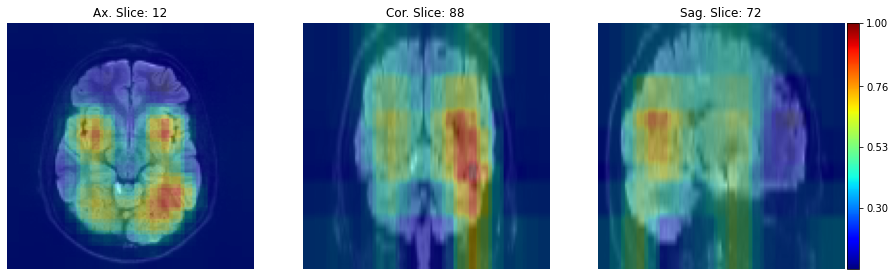

In [13]:
phm.plot_heatmap(np.squeeze(volume, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True, 
                negative=False)

## CI_B and LSX

In [ ]:
def iterate_hm_generation(X_occ, X_patient, Y_patient, model):
    X_occ_2 = np.array(X_occ)
    data_loader_1 = np.ones(shape=[len(X_occ_2),1])
    data_loader_2 = X_occ_2
    data_loader_3 = np.repeat((X_patient,), repeats=len(X_occ_2), axis=0)
    data_occ = tf.data.Dataset.from_tensor_slices((data_loader_1,data_loader_2,data_loader_3))
    data_occ_labels = tf.data.Dataset.from_tensor_slices(np.repeat((Y_patient,), repeats=len(X_occ_2), axis=0))
    occ_loader = tf.data.Dataset.zip((data_occ, data_occ_labels))
    data_occ_full = occ_loader.batch(5, drop_remainder = True)
    preds_occ = predict_ontram(model, data = data_occ_full)
    #TODO: count per iteration...
    return preds_occ

pred_res_occ =  {"cdf": [], "pdf" : np.zeros(shape=(len(X_occ_2), 3)), "pred_class": [], "nll": []} #empty dict


In [ ]:
for i in range(int(len(X_occ_2)/100)):
    iter_res = iterate_hm_generation(X_occ[(i*100):(i*100)+100], X_tab[0], Y_mrs_test[0], model)    
    
    for j in range(len(iter_res['pdf'])):
        pred_res_occ['pdf'][(i*100)+j] = iter_res['pdf'][j]

In [ ]:
# function for preprocessing
def train_preprocessing2(data, label):
    """Process training data."""
    volume = data[0] # intercept: image
    tabular = data[1] # shift: tabular
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return (volume, tabular), label

# Define data sets
train_data_2 = tf.data.Dataset.from_tensor_slices((X_train[:ntrain], X_tab_train[:ntrain]))
train_labels_2 = tf.data.Dataset.from_tensor_slices((Y_train_MRS[:ntrain]))

valid_data_2 = tf.data.Dataset.from_tensor_slices((X_valid[:ntrain], X_tab_valid[:ntrain]))
valid_labels_2 = tf.data.Dataset.from_tensor_slices((Y_valid_MRS[:nvalid]))

test_data_2 = tf.data.Dataset.from_tensor_slices((X_test[:ntest], X_tab_test[:ntest]))
test_labels_2 = tf.data.Dataset.from_tensor_slices((Y_test_MRS[:ntest]))

train_loader_2 = tf.data.Dataset.zip((train_data_2, train_labels_2))
validation_loader_2 = tf.data.Dataset.zip((valid_data_2, valid_labels_2))
test_loader_2 = tf.data.Dataset.zip((test_data_2, test_labels_2))

train_dataset_MRS_2 = (train_loader_2.shuffle(ntrain)
                 .map(train_preprocessing2)
                 .batch(batch_size))

validation_dataset_MRS_2 = (validation_loader_2.batch(batch_size))

test_dataset_MRS_2 = (test_loader_2.batch(len(X_test[:ntest])))

In [ ]:
X_tab_train[:ntrain].shape

In [ ]:
X_train.shape

In [ ]:
X_occ_2.shape

In [ ]:
np.repeat((Y_test_MRS[0],), repeats=len(X_occ_2), axis=0)

In [ ]:
data_loader_1 = X_occ_2
#add LSX
data_occ = tf.data.Dataset.from_tensor_slices((data_loader_1))

data_occ_labels = tf.data.Dataset.from_tensor_slices(np.repeat((Y_test_MRS[0],), 
                                                               repeats=len(X_occ_2), axis=0))


occ_loader = tf.data.Dataset.zip((data_occ, data_occ_labels))
data_occ_full = occ_loader.batch(5, drop_remainder = True)

In [ ]:
CI_B = utils.img_model_linear(X_train.shape[1:], 1)
LS_X = utils.mod_linear_shift(X_tab_train.shape[1])
mod_ontram_CIBLSX = ontram(CI_B, LS_X)
mod_ontram_CIBLSX.compile(optimizer = keras.optimizers.Adam(),
                loss = ontram_loss(C, batch_size),
                metrics = [ontram_acc(C, batch_size)])    
mod_ontram_CIBLSX.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_1_1_ontram_CIBLSX_.h5')

In [ ]:
params = get_parameters(mod_ontram_CIBLSX)

In [ ]:
data_loader_1 = X_occ_2
#add LSX
data_occ = tf.data.Dataset.from_tensor_slices((data_loader_1))

data_occ_labels = tf.data.Dataset.from_tensor_slices(np.repeat((Y_test_MRS[0],), 
                                                               repeats=len(X_occ_2), axis=0))


occ_loader = tf.data.Dataset.zip((data_occ, data_occ_labels))
data_occ_full = occ_loader.batch(5, drop_remainder = True)

# Jonas

## OCC Jonas

In [ ]:
def stroke_binary_3d_softmax(input_dim = (128, 128, 28,1), 
                     output_dim = 2,
                     last_activation = "softmax"):
    
    initializer = keras.initializers.he_normal(seed = 2202)
    
    #input
    inputs = keras.Input(input_dim)
    
    # conv block 0
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # conv block 1
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # conv block 2
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # conv block 3
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    x = layers.Flatten()(x)
   
    # flat block
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dropout(0.3)(x)


    out = layers.Dense(units=output_dim, activation = last_activation)(x) # softmax (output_dim must be at least 2)

    # Define the model.
    model_3d_softmax = Model(inputs=inputs, outputs=out)
    
    return model_3d_softmax

In [ ]:
heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

## Generate all possible occlusions
X_occ = []
xyz = []
for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
            X_occ.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1)) #3 changed from 1 manually
            xyz.append((x,y,z))

preds_occ_jonas = jon_softmax_occ.predict(data_occ_full)


for i in range(len(X_occ)):
    x,y,z = xyz[i]
    heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += preds_occ_jonas[i][1]
    heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

hm_jonas = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel'

In [ ]:
phm.plot_heatmap(np.squeeze(X_test[1], axis=-1), hm_jonas,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

In [ ]:
ontram_1 = ontram(img_model_linear(X_train.shape[1:], 1))
ontram_2 = ontram(img_model_linear(X_train.shape[1:], 1))
ontram_3 = ontram(img_model_linear(X_train.shape[1:], 1))
ontram_4 = ontram(img_model_linear(X_train.shape[1:], 1))
ontram_5 = ontram(img_model_linear(X_train.shape[1:], 1))

ontram_1.compile(optimizer=keras.optimizers.Adam(),
                                    loss=ontram_loss(C, batch_size),
                                    metrics=[ontram_acc(C, batch_size)])

ontram_2.compile(optimizer=keras.optimizers.Adam(),
                                    loss=ontram_loss(C, batch_size),
                                    metrics=[ontram_acc(C, batch_size)])
ontram_3.compile(optimizer=keras.optimizers.Adam(),
                                    loss=ontram_loss(C, batch_size),
                                    metrics=[ontram_acc(C, batch_size)])

ontram_4.compile(optimizer=keras.optimizers.Adam(),
                                    loss=ontram_loss(C, batch_size),
                                    metrics=[ontram_acc(C, batch_size)])

ontram_5.compile(optimizer=keras.optimizers.Adam(),
                                    loss=ontram_loss(C, batch_size),
                                    metrics=[ontram_acc(C, batch_size)])

ontram_1.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_ontram_CIB_0.h5')
ontram_2.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_ontram_CIB_1.h5')
ontram_3.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_ontram_CIB_2.h5')
ontram_4.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_ontram_CIB_3.h5')
ontram_5.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_ontram_CIB_4.h5')

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid(x):
    return np.log(x / (1 - x))

In [ ]:
occ_size = (14, 14, 10)
occ_stride = 6
###per patient input
volume = np.expand_dims(X_train, axis = -1)[0]

###
occlusion_size = np.array(occ_size)
normalize = True
both_directions = False
invert_hm = "pred_class"
occlusion_stride = occ_stride
input_shape = (128,128,28,1)

In [ ]:
occ_size = (16, 16, 12)
occ_stride = 4

model_names = [ontram_1, ontram_2, ontram_3, ontram_4, ontram_5]

h_l = []
for model_name in model_names:
    
    heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
    heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

    ## Generate all possible occlusions
    X = []
    xyz = []
    for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
        X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
        xyz.append((x,y,z))
    
    X = np.array(X)
    out = sigmoid(model_name.predict(X)) # do prediction for all occlusions at once
    
    ## Add predictions to heatmap and count number of predictions per voxel
    for i in range(len(xyz)):
        x,y,z = xyz[i]
        heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[i]
        heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

    hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel
    
    hm = ((hm - hm.min())/(hm.max()-hm.min()))    
    h_l.append(hm)

In [ ]:
occ_size = (16, 16, 12)
occ_stride = 4

h_l = []
for i in range(5):
    model_jon = stroke_binary_3d_softmax()
    model_jon.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                metrics=["acc", tf.keras.metrics.AUC()])
    model_jon.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_jonas_{}.h5'.format(i))
    heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
    heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

    ## Generate all possible occlusions
    X = []
    xyz = []
    for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
        X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
        xyz.append((x,y,z))
    
    X = np.array(X)
    out = model_jon.predict(X) # do prediction for all occlusions at once
    
    ## Add predictions to heatmap and count number of predictions per voxel
    for i in range(len(xyz)):
        x,y,z = xyz[i]
        heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[0,i]
        heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

    hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel
    
    hm = ((hm - hm.min())/(hm.max()-hm.min()))    
    h_l.append(hm)

In [ ]:
## Average over all models
h_l = np.array(h_l)
h_l = np.expand_dims(h_l, axis = -1)
heatmap = np.mean(h_l, axis = 0)
heatmap = ((heatmap - heatmap.min())/(heatmap.max()-heatmap.min()))

In [ ]:
phm.plot_heatmap(np.squeeze(X_test[2], axis=-1), np.squeeze(heatmap, axis=(3,4)),
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

In [ ]:
ontram_1.predict(data_occ_full)

## Jonas Ensemble

In [ ]:
from tensorflow.keras.models import Sequential, Model

def stroke_binary_3d_softmax(input_dim = (128, 128, 28,1), 
                     output_dim = 2,
                     last_activation = "softmax"):
    
    initializer = keras.initializers.he_normal(seed = 2202)
    
    #input
    inputs = keras.Input(input_dim)
    
    # conv block 0
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # conv block 1
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # conv block 2
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    # conv block 3
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    #x = layers.Flatten()(x)
    x = layers.GlobalAveragePooling3D()(x) 
    # flat block
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dropout(0.3)(x)
    
    out = layers.Dense(units=output_dim, activation = last_activation)(x) # softmax (output_dim must be at least 2)

    # Define the model.
    model_3d_softmax = Model(inputs=inputs, outputs=out)
    
    return model_3d_softmax

In [ ]:
occ_size = (14, 14, 10)
occ_stride = 6

###per patient input
volume = np.expand_dims(X_train, axis = -1)[0]

###
occlusion_size = np.array(occ_size)
normalize = True
both_directions = False
invert_hm = "pred_class"
occlusion_stride = occ_stride
input_shape = (128,128,28,1)
volume = volume.reshape(input_shape)

In [ ]:
h_l = []
for j in range(5):
    model_jon = stroke_binary_3d_softmax()
    model_jon.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                metrics=["acc", tf.keras.metrics.AUC()])
    model_jon.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_jonas_{}.h5'.format(j))
    heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
    heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

    ## Generate all possible occlusions
    X = []
    xyz = []
    for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
        X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
        xyz.append((x,y,z))
    
    X = np.array(X)
    out = model_jon.predict(X) # do prediction for all occlusions at once
    
    ## Add predictions to heatmap and count number of predictions per voxel
    for i in range(len(xyz)):
        x,y,z = xyz[i]
        heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[i,1]
        heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

    hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel
    
    hm = ((hm - hm.min())/(hm.max()-hm.min()))    
    h_l.append(hm)

In [ ]:
## Average over all models
h_l = np.array(h_l)
h_l = np.expand_dims(h_l, axis = -1)
heatmap = np.mean(h_l, axis = 0)
heatmap = ((heatmap - heatmap.min())/(heatmap.max()-heatmap.min()))

In [ ]:
phm.plot_heatmap(np.squeeze(X_test[5], axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

In [ ]:
model_jon = stroke_binary_3d_softmax()
model_jon.compile(loss=tf.keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
            metrics=["acc", tf.keras.metrics.AUC()])
model_jon.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/ensembling_results/model_jonas_{}.h5'.format(1))


# Jonas pre-trained Softmax

In [ ]:
weights = '/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_softmax_V1/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_softmax_activation_13.h5'

input_dim = X_train.shape[1:]
output_dim = 2

layer_connection = "globalAveragePooling"
last_activation = "softmax"

# call model
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

model_3d.load_weights(weights)

In [ ]:
occ_size = (14, 14, 10)
occ_stride = 6
###per patient input
volume = np.expand_dims(X_train, axis = -1)[0]

###
occlusion_size = np.array(occ_size)
normalize = True
both_directions = False
invert_hm = "pred_class"
occlusion_stride = occ_stride
input_shape = (128,128,28,1)
volume = volume.reshape(input_shape)

heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

## Generate all possible occlusions
X_occ = []
xyz = []
for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
            X_occ.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1)) #3 changed from 1 manually
            xyz.append((x,y,z))


In [ ]:
X = np.array(X_occ)

In [ ]:
out = model_3d.predict(X) 

In [ ]:
for i in range(len(X_occ)):
    x,y,z = xyz[i]
    heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[i,1]
    heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

hm_jonas = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel'

In [ ]:
phm.plot_heatmap(np.squeeze(X_test[8], axis=-1), hm_jonas,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

# Jonas pre-trained no folding simple

In [ ]:
path = '/tf/notebooks/schnemau/xAI_stroke_3d/weights/andrea_split/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_14.h5'

input_dim = X_train.shape[1:]
output_dim = 1

layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

# call model
model_3d2 = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d2.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

model_3d2.load_weights(path)


In [ ]:
occ_size = (14, 14, 10)
occ_stride = 6
###per patient input
volume = np.expand_dims(X_train, axis = -1)[0]

###
occlusion_size = np.array(occ_size)
normalize = True
both_directions = False
invert_hm = "pred_class"
occlusion_stride = occ_stride
input_shape = (128,128,28,1)
volume = volume.reshape(input_shape)

heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

## Generate all possible occlusions
X_occ = []
xyz = []
for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
            X_occ.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1)) #3 changed from 1 manually
            xyz.append((x,y,z))


X = np.array(X_occ)
out = model_3d2.predict(X) 
for i in range(len(X_occ)):
    x,y,z = xyz[i]
    heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[i]
    heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

hm_jonas = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel'

In [ ]:
phm.plot_heatmap(np.squeeze(X_test[8], axis=-1), hm_jonas,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

# Jonas pre-trained no folding ensemble

In [ ]:
occ_size = (14, 14, 10)
occ_stride = 6
###per patient input
volume = np.expand_dims(X_train, axis = -1)[0]

###
occlusion_size = np.array(occ_size)
normalize = True
both_directions = False
invert_hm = "pred_class"
occlusion_stride = occ_stride
input_shape = (128,128,28,1)
volume = volume.reshape(input_shape)

In [ ]:
h_l = []
for j in range(10,15):
    model_3d2 = md.stroke_binary_3d(input_dim = X_train.shape[1:],
                                output_dim = 1,
                                layer_connection = "globalAveragePooling",
                                last_activation = "sigmoid")
    model_3d2.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
        metrics=["acc", tf.keras.metrics.AUC()])

    model_3d2.load_weights('/tf/notebooks/schnemau/xAI_stroke_3d/weights/andrea_split/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_{}.h5'.format(j))  
    
    heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
    heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

    ## Generate all possible occlusions
    X = []
    xyz = []
    for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
            volume, size = occlusion_size, stride = occlusion_stride)):
        X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
        xyz.append((x,y,z))
    
    X = np.array(X)

    out = model_3d2.predict(X) 

    #out = sigmoid(model_ontram.predict(X)) # do prediction for all occlusions at once
    
    ## Add predictions to heatmap and count number of predictions per voxel
    for i in range(len(xyz)):
        x,y,z = xyz[i]
        heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[i]
        heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

    hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel
    
    hm = ((hm - hm.min())/(hm.max()-hm.min()))    
    h_l.append(hm)

In [ ]:
## Average over all models
h_l = np.array(h_l)
h_l = np.expand_dims(h_l, axis = -1)
heatmap = np.mean(h_l, axis = 0)
heatmap = ((heatmap - heatmap.min())/(heatmap.max()-heatmap.min()))

In [ ]:
phm.plot_heatmap(np.squeeze(X_test[8], axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True, 
                negative=False)